In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

parent_path = os.path.abspath('..')
if parent_path not in sys.path:
    sys.path.append(parent_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from lib.calendar import get_market_calendar
from lib.utils import is_business_day
from lib.exog_data import get_yfinance_data
from lib.windows import get_train_test_index

$$
\hat{\Delta \ln(USD\_CLP_{t+i})} =
f(\mathbf{X}_{t-j}, \boldsymbol{\theta}_i) + \varepsilon_t,
\quad \text{donde } i \in \{1, 2, 3\}, \, j \in \{0, 1, 2\}.
$$

$where$

$$\Delta \ln(USD\_CLP_{t+i}) \equiv \ln(USD\_CLP_{t+i}) - \ln(USD\_CLP_{t+i-1}),$$

$\text{y cada } \boldsymbol{\theta}_i \text{ corresponde a modelos independientes para cada horizonte de predicción (} t+i \text{).}$ 

### Market Calendar

In [177]:
market_calendar = get_market_calendar("CME_Currency", ["2016-12-30", "2024-10-24"])
market_calendar[:16]

DatetimeIndex(['2016-12-30', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17',
               '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23'],
              dtype='datetime64[ns]', freq='C')

### Exchange Rate

In [262]:
df_exchange_rate = pd.read_csv("../data/raw/exchangeRateIATA.csv", sep=";")
df_exchange_rate["dates"] = pd.to_datetime(df_exchange_rate["dates"])
df_exchange_rate = df_exchange_rate.sort_values(by="dates", ascending=True).reset_index(drop=True)

df_exchange_rate.rename(columns={"iata":"usd_clp"}, inplace=True)

# En la base original existen cambios de precio los días sabado, lo que es imposible por las características del mercado.
# Se asume error en las fechas y se rezaga -1 periodo para corregir
df_exchange_rate["usd_clp"] = df_exchange_rate["usd_clp"].shift(-1)


# Mantener los días no hábiles en la base propagando el último valor válido introducirá error en cálculo de estimadores.
# Se utiliza calendario de mercado cambiario para determinar los dias hábiles.
df_exchange_rate["dummy_bd"] = df_exchange_rate["dates"].apply(lambda x: is_business_day(x, market_calendar))
df_exchange_rate = df_exchange_rate.query("dummy_bd == 1").reset_index(drop=True)
df_exchange_rate.drop("dummy_bd", axis=1, inplace=True)

df_exchange_rate["usd_clp_t-1"] = df_exchange_rate["usd_clp"].shift(1)
df_exchange_rate["usd_clp_t+1"] = df_exchange_rate["usd_clp"].shift(-1)
df_exchange_rate["usd_clp_t+2"] = df_exchange_rate["usd_clp"].shift(-2)
df_exchange_rate["usd_clp_t+3"] = df_exchange_rate["usd_clp"].shift(-3)


# Se calcula primera diferencia para convertir la serie a estacionaria
df_exchange_rate["y_t+0"] = np.log(df_exchange_rate["usd_clp_t-1"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t-1"] = df_exchange_rate["y_t+0"].shift(1)
df_exchange_rate["y_t-2"] = df_exchange_rate["y_t+0"].shift(2)
df_exchange_rate["y_t+1"] = np.log(df_exchange_rate["usd_clp_t+1"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t+2"] = np.log(df_exchange_rate["usd_clp_t+2"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t+3"] = np.log(df_exchange_rate["usd_clp_t+3"]) - np.log(df_exchange_rate["usd_clp"])

df_exchange_rate.tail()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3
2015,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509
2016,2024-10-21,954.0,942.0,954.0,951.0,NaN,-0.012658,-0.002125,-0.007475,0.000000,-0.003150,NaN
2017,2024-10-22,954.0,954.0,951.0,NaN,NaN,0.000000,-0.012658,-0.002125,-0.003150,NaN,NaN
2018,2024-10-23,951.0,954.0,NaN,NaN,NaN,0.003150,0.000000,-0.012658,NaN,NaN,NaN
2019,2024-10-24,NaN,951.0,NaN,NaN,NaN,NaN,0.003150,0.000000,NaN,NaN,NaN


### Copper Prices

In [263]:
df_copper = get_yfinance_data(ticker_symbol="HG=F", date_interval=["2016-12-30", "2024-10-24"], name="copper")
df_copper.head(5)

,dates,copper_close
0,2016-12-30,2.4975
1,2017-01-03,2.4810
2,2017-01-04,2.5480
3,2017-01-05,2.5295
4,2017-01-06,2.5380


In [280]:
df = df_exchange_rate.merge(df_copper, how="left", on="dates")
df.tail(14)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close
2006,2024-10-07,925.0,916.0,926.0,930.0,934.0,-0.009777,-0.009874,-0.003313,0.001080,0.005391,0.009683,4.5190
2007,2024-10-08,926.0,925.0,930.0,934.0,932.0,-0.001080,-0.009777,-0.009874,0.004310,0.008602,0.006459,4.4120
2008,2024-10-09,930.0,926.0,934.0,932.0,927.0,-0.004310,-0.001080,-0.009777,0.004292,0.002148,-0.003231,4.3550
2009,2024-10-10,934.0,930.0,932.0,927.0,928.0,-0.004292,-0.004310,-0.001080,-0.002144,-0.007523,-0.006445,4.3850
2010,2024-10-11,932.0,934.0,927.0,928.0,933.0,0.002144,-0.004292,-0.004310,-0.005379,-0.004301,0.001072,4.4515
2011,2024-10-14,927.0,932.0,928.0,933.0,940.0,0.005379,0.002144,-0.004292,0.001078,0.006452,0.013926,4.3635
2012,2024-10-15,928.0,927.0,933.0,940.0,942.0,-0.001078,0.005379,0.002144,0.005373,0.012848,0.014974,4.3005
2013,2024-10-16,933.0,928.0,940.0,942.0,954.0,-0.005373,-0.001078,0.005379,0.007475,0.009600,0.022258,4.3315
2014,2024-10-17,940.0,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.2865
2015,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.3460


In [281]:
# Imputar nulos precio cobre con promedio entr t-1 y t+1
df['copper_close'] = df['copper_close'].fillna((df['copper_close'].shift(1) + df['copper_close'].shift(-1)) / 2)

In [282]:
df.tail(14)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close
2006,2024-10-07,925.0,916.0,926.0,930.0,934.0,-0.009777,-0.009874,-0.003313,0.001080,0.005391,0.009683,4.5190
2007,2024-10-08,926.0,925.0,930.0,934.0,932.0,-0.001080,-0.009777,-0.009874,0.004310,0.008602,0.006459,4.4120
2008,2024-10-09,930.0,926.0,934.0,932.0,927.0,-0.004310,-0.001080,-0.009777,0.004292,0.002148,-0.003231,4.3550
2009,2024-10-10,934.0,930.0,932.0,927.0,928.0,-0.004292,-0.004310,-0.001080,-0.002144,-0.007523,-0.006445,4.3850
2010,2024-10-11,932.0,934.0,927.0,928.0,933.0,0.002144,-0.004292,-0.004310,-0.005379,-0.004301,0.001072,4.4515
2011,2024-10-14,927.0,932.0,928.0,933.0,940.0,0.005379,0.002144,-0.004292,0.001078,0.006452,0.013926,4.3635
2012,2024-10-15,928.0,927.0,933.0,940.0,942.0,-0.001078,0.005379,0.002144,0.005373,0.012848,0.014974,4.3005
2013,2024-10-16,933.0,928.0,940.0,942.0,954.0,-0.005373,-0.001078,0.005379,0.007475,0.009600,0.022258,4.3315
2014,2024-10-17,940.0,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.2865
2015,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.3460


In [373]:
df["copper_t+0"] = np.log(df["copper_close"]) - np.log(df["copper_close"].shift())
df["copper_t-1"] = df["copper_t+0"].shift(1)
df["copper_t-2"] = df["copper_t+0"].shift(2)
df["copper_t-3"] = df["copper_t+0"].shift(3)
df["copper_t-4"] = df["copper_t+0"].shift(4)
df["copper_t-5"] = df["copper_t+0"].shift(5)

df.head(6)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
0,2017-01-09,668.0,668.0,668.0,670.0,678.0,0.000000,0.010425,-0.001483,0.000000,0.002990,0.014859,2.5300,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-10,668.0,668.0,670.0,678.0,672.0,0.000000,0.000000,0.010425,0.002990,0.014859,0.005970,2.6035,0.028637,NaN,NaN,NaN,NaN,NaN
2,2017-01-11,670.0,668.0,678.0,672.0,660.0,-0.002990,0.000000,0.000000,0.011870,0.002981,-0.015038,2.6010,-0.000961,0.028637,NaN,NaN,NaN,NaN
3,2017-01-12,678.0,670.0,672.0,660.0,661.0,-0.011870,-0.002990,0.000000,-0.008889,-0.026907,-0.025393,2.6605,0.022618,-0.000961,0.028637,NaN,NaN,NaN
4,2017-01-13,672.0,678.0,660.0,661.0,661.0,0.008889,-0.011870,-0.002990,-0.018019,-0.016505,-0.016505,2.6805,0.007489,0.022618,-0.000961,0.028637,NaN,NaN
5,2017-01-16,660.0,672.0,661.0,661.0,659.0,0.018019,0.008889,-0.011870,0.001514,0.001514,-0.001516,2.6485,-0.012010,0.007489,0.022618,-0.000961,0.028637,NaN


In [374]:
df.dropna(subset=["usd_clp","copper_t-5"], inplace=True)
df.reset_index(inplace=True, drop=True)

In [375]:
df.head()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
0,2017-01-17,661.0,660.0,661.0,659.0,663.0,-0.001514,0.018019,0.008889,0.000000,-0.003030,0.003021,2.6165,-0.012156,-0.012010,0.007489,0.022618,-0.000961,0.028637
1,2017-01-18,661.0,661.0,659.0,663.0,670.0,0.000000,-0.001514,0.018019,-0.003030,0.003021,0.013524,2.6080,-0.003254,-0.012156,-0.012010,0.007489,0.022618,-0.000961
2,2017-01-19,659.0,661.0,663.0,670.0,658.0,0.003030,0.000000,-0.001514,0.006051,0.016554,-0.001519,2.6015,-0.002495,-0.003254,-0.012156,-0.012010,0.007489,0.022618
3,2017-01-20,663.0,659.0,670.0,658.0,653.0,-0.006051,0.003030,0.000000,0.010503,-0.007570,-0.015198,2.6170,0.005940,-0.002495,-0.003254,-0.012156,-0.012010,0.007489
4,2017-01-23,670.0,663.0,658.0,653.0,652.0,-0.010503,-0.006051,0.003030,-0.018073,-0.025701,-0.027233,2.6395,0.008561,0.005940,-0.002495,-0.003254,-0.012156,-0.012010


In [376]:
df.tail()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
2004,2024-10-17,940.0,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.2865,-0.010443,0.007183,-0.014543,-0.019967,0.015051,0.006865
2005,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.3460,0.013785,-0.010443,0.007183,-0.014543,-0.019967,0.015051
2006,2024-10-21,954.0,942.0,954.0,951.0,NaN,-0.012658,-0.002125,-0.007475,0.000000,-0.003150,NaN,4.3230,-0.005306,0.013785,-0.010443,0.007183,-0.014543,-0.019967
2007,2024-10-22,954.0,954.0,951.0,NaN,NaN,0.000000,-0.012658,-0.002125,-0.003150,NaN,NaN,4.3480,0.005766,-0.005306,0.013785,-0.010443,0.007183,-0.014543
2008,2024-10-23,951.0,954.0,NaN,NaN,NaN,0.003150,0.000000,-0.012658,NaN,NaN,NaN,4.3045,-0.010055,0.005766,-0.005306,0.013785,-0.010443,0.007183


In [378]:
# Calcular correlaciones y ordenar por la columna "y_t+1"
correlation_matrix = df.corr()[["y_t+1", "y_t+2", "y_t+3"]].sort_values("y_t+1")

# Crear un heatmap básico con pandas
heatmap = correlation_matrix.style.background_gradient(cmap="coolwarm").format("{:.2f}")

# Mostrar el heatmap
heatmap

,y_t+1,y_t+2,y_t+3
copper_t+0,-0.25,-0.28,-0.26
y_t+0,-0.22,-0.13,-0.10
copper_t-1,-0.19,-0.17,-0.16
copper_t-2,-0.08,-0.08,-0.07
copper_t-3,-0.05,-0.04,-0.03
usd_clp_t-1,-0.04,-0.05,-0.05
usd_clp,-0.02,-0.04,-0.05
copper_t-4,-0.02,-0.01,-0.01
copper_close,-0.01,0.00,0.01
dates,0.01,0.01,0.01


In [90]:
# no puedo considerar dias no habiles porque las primeras diferencias se vuelven 0 artificialmente y afectarán los estimadores -> se agrega condicion if not business_day = 0 

In [379]:
specs = {
    "RW":["y_t+0"],
    "DRW":["y_t+0"],
    "AR(1)":["y_t+0"],
    "AR(2)":["y_t+0", "y_t-1"],
    "COPPER(2,1)":["y_t+0", "y_t-1", "copper_t+0"],
    "COPPER(2,2)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1"],
    "COPPER(2,3)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2"],
    "COPPER(2,4)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3"],
    "COPPER(2,5)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4"],
    "COPPER(2,6)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4", "copper_t-5"],
    "COPPER(1,1)":["y_t+0", "copper_t+0"],
    "COPPER(1,2)":["y_t+0", "copper_t+0", "copper_t-1"],
    "COPPER(1,3)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2"],
    "COPPER(1,4)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3"],
    "COPPER(1,5)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4"],
    "COPPER(1,6)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4", "copper_t-5"],
}

In [ ]:
update_window_methods = ["rolling", "expanding"]
first_windows_ratio = [.3, .5, .7]
steps_ahead = 3

metrics = {
    "update_method":[],
    "first_windows_ratio":[],
    "scpecification":[],
    "first_train_date":[],
    "last_train_date":[],
    "step_ahead":[],
    "y":[],
    "y_pred":[],
    "sq_error":[],
    "usd_clp":[],
    "usd_clp_t":[]
}


for update_method in update_window_methods:
    for window_ratio in first_windows_ratio:
        indexes = get_train_test_index(df, ratio=window_ratio, method=update_method, steps_ahead=steps_ahead)
        
        for train_idx, test_idx in indexes:
            df_train = df.iloc[train_idx,:]
            df_test = df.iloc[test_idx,:]
            first_train_date = df_train["dates"].min()
            last_train_date = df_train["dates"].max()

            for spec_name, spec_variables in specs.items():
                X_train = df_train[spec_variables]

                if spec_name == "RW":
                    y_pred = np.mean(X_train)
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_test = df_test.loc[idx, f"y_t+{step}"]
                        
                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)
                        
                
                elif spec_name == "DRW":
                    y_pred = 0.0
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_test = df_test.loc[idx, f"y_t+{step}"]

                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)
                
                else:
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_train = df_train[f"y_t+{step}"]
                        
                        X_test = df_test.loc[[idx], spec_variables]
                        y_test = df_test.loc[idx, f"y_t+{step}"]
    
                        model = LinearRegression(fit_intercept=True)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)[0]
                        
                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)


In [413]:
df_results = pd.DataFrame(metrics)

In [428]:
df_results["usd_clp_t_pred"] = df_results["usd_clp"] * (1 + df_results["y_pred"])
df_results["nominal_error"] = np.abs(df_results["usd_clp_t_pred"] - df_results["usd_clp_t"])

In [470]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23'")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n       mse      rmse  \
update_method first_windows_ratio scpecification                             
rolling       0.7                 COPPER(2,4)     1799  0.000176  0.013280   
expanding     0.5                 COPPER(2,4)     1805  0.000176  0.013281   
              0.3                 COPPER(2,4)     1805  0.000176  0.013281   
rolling       0.7                 COPPER(1,4)     1799  0.000176  0.013284   
                                  COPPER(2,5)     1799  0.000176  0.013284   

                                                   std_dev  
update_method first_windows_ratio scpecification            
rolling       0.7                 COPPER(2,4)     0.000635  
expanding     0.5                 COPPER(2,4)     0.000633  
              0.3                 COPPER(2,4)     0.000633  
rolling       0.7                 COPPER(1,4)     0.000646  
                                  COPPER(2,5)     0.000637

In [389]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 1")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n       mse      rmse  \
update_method first_windows_ratio scpecification                            
expanding     0.7                 COPPER(2,4)     601  0.000069  0.008282   
                                  COPPER(2,5)     601  0.000069  0.008283   
                                  COPPER(2,6)     601  0.000069  0.008289   
rolling       0.7                 COPPER(2,4)     601  0.000069  0.008296   
expanding     0.7                 COPPER(2,3)     601  0.000069  0.008297   

                                                   std_dev  
update_method first_windows_ratio scpecification            
expanding     0.7                 COPPER(2,4)     0.000253  
                                  COPPER(2,5)     0.000253  
                                  COPPER(2,6)     0.000254  
rolling       0.7                 COPPER(2,4)     0.000251  
expanding     0.7                 COPPER(2,3)     0.000257

In [390]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 2")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n       mse      rmse  \
update_method first_windows_ratio scpecification                            
rolling       0.7                 COPPER(2,4)     600  0.000173  0.013168   
expanding     0.3                 COPPER(2,4)     602  0.000173  0.013169   
              0.5                 COPPER(2,4)     602  0.000173  0.013169   
rolling       0.7                 COPPER(2,5)     600  0.000174  0.013173   
expanding     0.5                 COPPER(2,5)     602  0.000174  0.013175   

                                                   std_dev  
update_method first_windows_ratio scpecification            
rolling       0.7                 COPPER(2,4)     0.000638  
expanding     0.3                 COPPER(2,4)     0.000639  
              0.5                 COPPER(2,4)     0.000639  
rolling       0.7                 COPPER(2,5)     0.000642  
expanding     0.5                 COPPER(2,5)     0.000643

In [393]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 3")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head(10)

n       mse      rmse  \
update_method first_windows_ratio scpecification                            
expanding     0.5                 COPPER(1,4)     600  0.000287  0.016948   
              0.3                 COPPER(1,4)     600  0.000287  0.016948   
rolling       0.7                 COPPER(1,4)     598  0.000287  0.016952   
expanding     0.5                 COPPER(2,4)     600  0.000287  0.016952   
              0.3                 COPPER(2,4)     600  0.000287  0.016952   
rolling       0.7                 COPPER(2,4)     598  0.000287  0.016953   
expanding     0.3                 COPPER(1,5)     600  0.000287  0.016954   
              0.5                 COPPER(1,5)     600  0.000287  0.016954   
              0.3                 COPPER(1,6)     600  0.000288  0.016957   
              0.5                 COPPER(1,6)     600  0.000288  0.016957   

                                                   std_dev  
update_method first_windows_ratio scpecification            
expanding     0.5                 COPPER(1,4)     0.000843  
              0.3                 COPPER(1,4)     0.000843  
rolling       0.7                 COPPER(1,4)     0.000848  
expanding     0.5                 COPPER(2,4)     0.000842  
              0.3                 COPPER(2,4)     0.000842  
rolling       0.7                 COPPER(2,4)     0.000847  
expanding     0.3                 COPPER(1,5)     0.000844  
              0.5                 COPPER(1,5)     0.000844  
              0.3                 COPPER(1,6)     0.000847  
              0.5                 COPPER(1,6)     0.000847

In [398]:
(
df_results
    .query("last_train_date >= '2022-06-23' and update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)'")
    .groupby(["step_ahead"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

,n,mse,rmse,std_dev
step_ahead,,,,
1,601,0.000069,0.008296,0.000251
2,600,0.000173,0.013168,0.000638
3,598,0.000287,0.016953,0.000847


In [402]:
df_results.shape

(288864, 9)

In [442]:
graph_data_1 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==1")
graph_data_2 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==2")
graph_data_3 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==3")

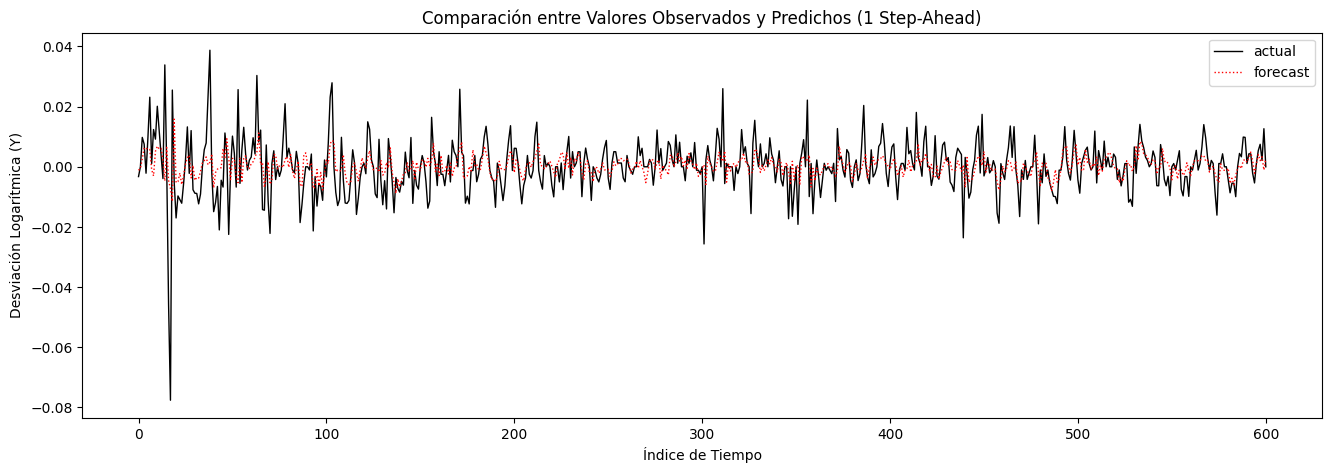

In [461]:
x = range(len(graph_data_1))

plt.figure(figsize=(16, 5))
plt.plot(x, graph_data_1["y"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, graph_data_1["y_pred"], linestyle='dotted', color='r', label='forecast', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Desviación Logarítmica (Y)")
plt.legend()
plt.grid(False)
plt.show()


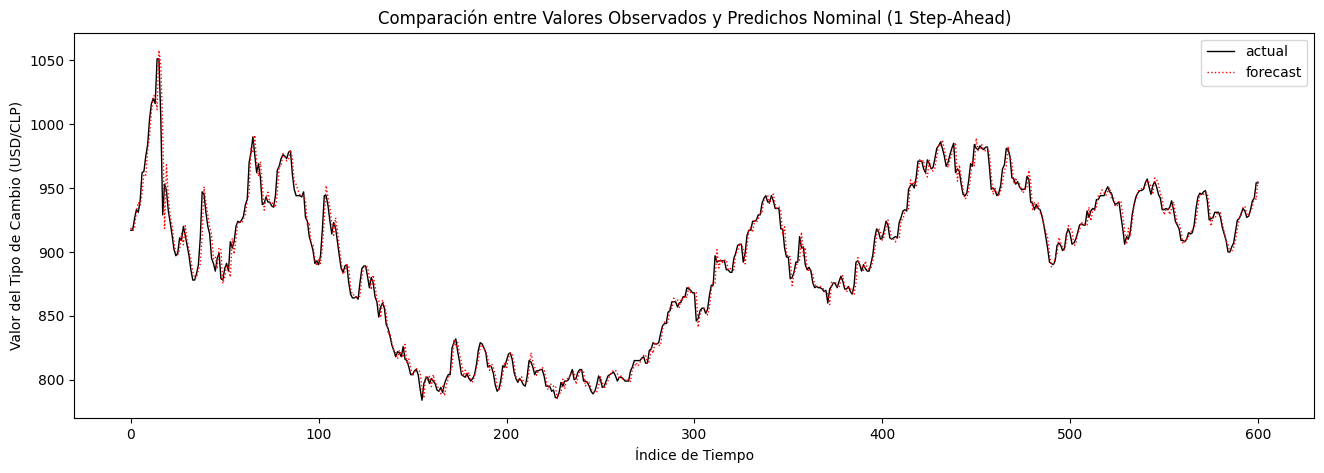

In [460]:
x = range(len(graph_data_1))

plt.figure(figsize=(16, 5))
plt.plot(x, graph_data_1["usd_clp_t"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, graph_data_1["usd_clp_t_pred"], linestyle='dotted', color='r', label='forecast', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos Nominal (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor del Tipo de Cambio (USD/CLP)")
plt.legend()
plt.grid(False)
plt.show()

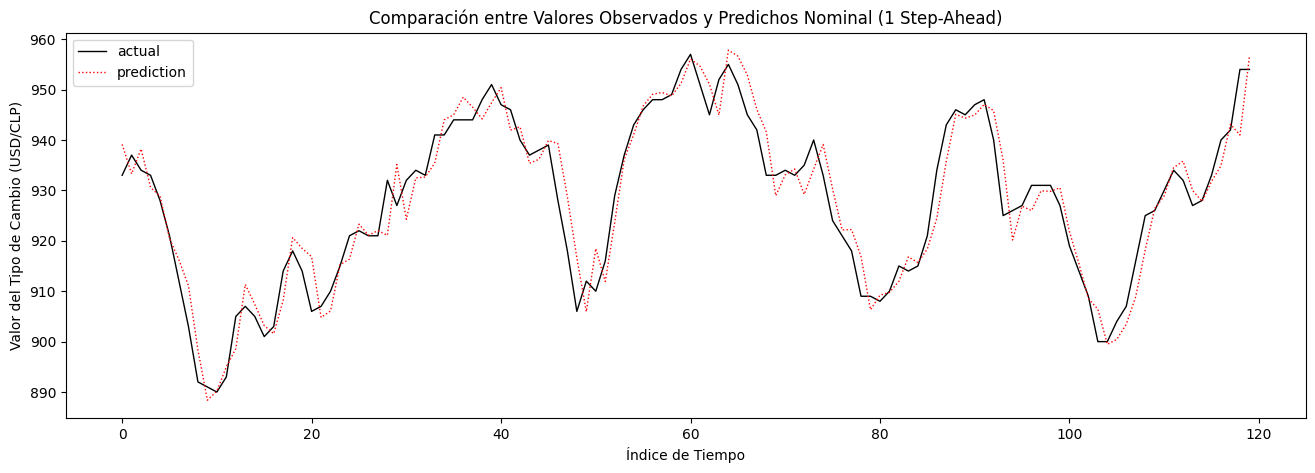

In [477]:
last_data = graph_data_1[-120:]

x = range(len(last_data))

plt.figure(figsize=(16, 5))
plt.plot(x, last_data["usd_clp_t"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, last_data["usd_clp_t_pred"], linestyle='dotted', color='r', label='prediction', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos Nominal (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor del Tipo de Cambio (USD/CLP)")
plt.legend()
plt.grid(False)
plt.show()

In [479]:
graph_data_1.tail(10)

,update_method,first_windows_ratio,scpecification,first_train_date,last_train_date,step_ahead,y,y_pred,sq_error,usd_clp,usd_clp_t,usd_clp_t_pred,nominal_error
143973,rolling,0.7,"COPPER(2,4)",2019-05-03,2024-10-07,1,0.004310,0.003133,1.385456e-06,926.0,930.0,928.901433,1.098567
144021,rolling,0.7,"COPPER(2,4)",2019-05-06,2024-10-08,1,0.004292,0.004873,3.377330e-07,930.0,934.0,934.531890,0.531890
144069,rolling,0.7,"COPPER(2,4)",2019-05-07,2024-10-09,1,-0.002144,0.001936,1.664676e-05,934.0,932.0,935.808617,3.808617
144117,rolling,0.7,"COPPER(2,4)",2019-05-08,2024-10-10,1,-0.005379,-0.002155,1.039797e-05,932.0,927.0,929.991856,2.991856
144165,rolling,0.7,"COPPER(2,4)",2019-05-09,2024-10-11,1,0.001078,0.000894,3.387391e-08,927.0,928.0,927.828848,0.171152
144213,rolling,0.7,"COPPER(2,4)",2019-05-10,2024-10-14,1,0.005373,0.004069,1.702067e-06,928.0,933.0,931.775879,1.224121
144261,rolling,0.7,"COPPER(2,4)",2019-05-13,2024-10-15,1,0.007475,0.002036,2.957395e-05,933.0,940.0,934.900037,5.099963
144309,rolling,0.7,"COPPER(2,4)",2019-05-14,2024-10-16,1,0.002125,0.003322,1.431090e-06,940.0,942.0,943.122380,1.122380
144357,rolling,0.7,"COPPER(2,4)",2019-05-15,2024-10-17,1,0.012658,-0.001064,1.883049e-04,942.0,954.0,940.997688,13.002312
144405,rolling,0.7,"COPPER(2,4)",2019-05-16,2024-10-18,1,0.000000,0.002686,7.212600e-06,954.0,954.0,956.562090,2.562090


In [495]:
df.query("dates == '2024-10-18'")

/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_91479/3110281499.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df.query("dates == '2024-10-18'")


,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
2005,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.346,0.013785,-0.010443,0.007183,-0.014543,-0.019967,0.015051


<Axes: >

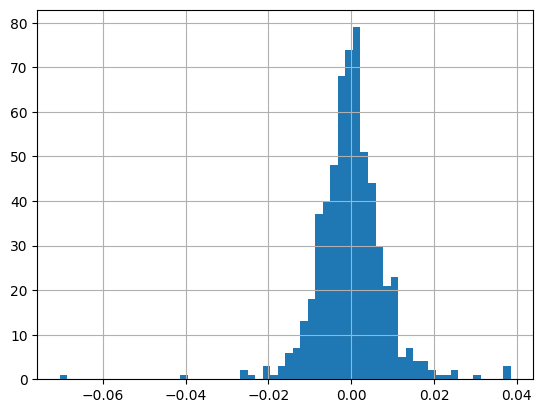

In [487]:
(graph_data_1["y"] - graph_data_1["y_pred"]).hist(bins=60)

<Axes: >

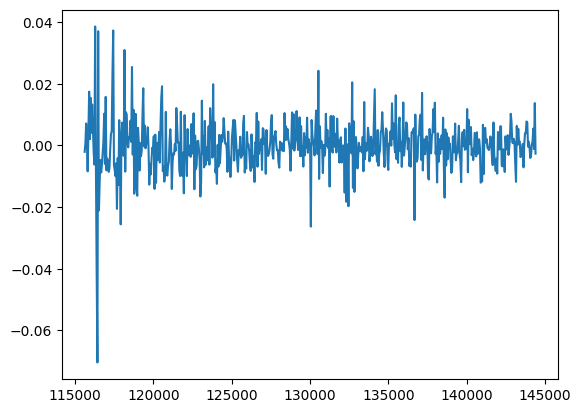

In [494]:
(graph_data_1["y"] - graph_data_1["y_pred"]).plot()

### Distribución de Errores Nominales por Horizonte de Predicción

In [480]:
df.tail(10)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
1999,2024-10-10,934.0,930.0,932.0,927.0,928.0,-0.004292,-0.004310,-0.001080,-0.002144,-0.007523,-0.006445,4.3850,0.006865,-0.013004,-0.023963,-0.000774,0.004543,-0.020665
2000,2024-10-11,932.0,934.0,927.0,928.0,933.0,0.002144,-0.004292,-0.004310,-0.005379,-0.004301,0.001072,4.4515,0.015051,0.006865,-0.013004,-0.023963,-0.000774,0.004543
2001,2024-10-14,927.0,932.0,928.0,933.0,940.0,0.005379,0.002144,-0.004292,0.001078,0.006452,0.013926,4.3635,-0.019967,0.015051,0.006865,-0.013004,-0.023963,-0.000774
2002,2024-10-15,928.0,927.0,933.0,940.0,942.0,-0.001078,0.005379,0.002144,0.005373,0.012848,0.014974,4.3005,-0.014543,-0.019967,0.015051,0.006865,-0.013004,-0.023963
2003,2024-10-16,933.0,928.0,940.0,942.0,954.0,-0.005373,-0.001078,0.005379,0.007475,0.009600,0.022258,4.3315,0.007183,-0.014543,-0.019967,0.015051,0.006865,-0.013004
2004,2024-10-17,940.0,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.2865,-0.010443,0.007183,-0.014543,-0.019967,0.015051,0.006865
2005,2024-10-18,942.0,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.3460,0.013785,-0.010443,0.007183,-0.014543,-0.019967,0.015051
2006,2024-10-21,954.0,942.0,954.0,951.0,NaN,-0.012658,-0.002125,-0.007475,0.000000,-0.003150,NaN,4.3230,-0.005306,0.013785,-0.010443,0.007183,-0.014543,-0.019967
2007,2024-10-22,954.0,954.0,951.0,NaN,NaN,0.000000,-0.012658,-0.002125,-0.003150,NaN,NaN,4.3480,0.005766,-0.005306,0.013785,-0.010443,0.007183,-0.014543
2008,2024-10-23,951.0,954.0,NaN,NaN,NaN,0.003150,0.000000,-0.012658,NaN,NaN,NaN,4.3045,-0.010055,0.005766,-0.005306,0.013785,-0.010443,0.007183


In [472]:
(
    df_results
    .query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)'")
    .groupby(["step_ahead"])[["nominal_error"]]
    .describe()
)

nominal_error                                                    \
                   count      mean       std       min       25%       50%   
step_ahead                                                                   
1                 1405.0  4.339783  4.793274  0.001015  1.314538  3.014086   
2                 1404.0  7.332586  7.398158  0.019956  2.446569  5.619880   
3                 1402.0  9.662634  9.085992  0.004819  3.564567  7.568629   

                                   
                  75%         max  
step_ahead                         
1            5.796894   63.516765  
2           10.151884  117.387614  
3           13.358626  132.966236

In [473]:
(
    df_results
    .query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'RW'")
    .groupby(["step_ahead"])[["nominal_error"]]
    .describe()
)

nominal_error                                                      \
                   count       mean        std       min       25%       50%   
step_ahead                                                                     
1                  601.0   5.504831   6.195500  0.110948  1.234529  3.856095   
2                  600.0   9.363662   9.267798  0.134813  3.132623  7.180861   
3                  598.0  12.287380  11.350651  0.111087  4.228684  9.773720   

                                   
                  75%         max  
step_ahead                         
1            7.775177   74.650243  
2           13.254357  121.664969  
3           17.215955  121.666120